# Numerical Optimization in Variational Quantum Eigensolvers

**Course:** Numerical Optimization  
**Project:** Optimization methods for VQE  

<h2>Introduction</h2>

<div style="text-align: justify;">

In many applications it is important to find the minimum eigenvalue of a matrix. For example, in chemistry, the minimum eigenvalue of a Hermitian matrix characterizing the molecule is the ground state energy of that system. In the future, the quantum phase estimation algorithm may be used to find the minimum eigenvalue. However, its implementation on useful problems requires circuit depths exceeding the limits of hardware available in the NISQ era. Thus, in 2014, Peruzzo et al. proposed VQE to estimate the ground state energy of a molecule using much shallower circuits [1].

Formally, given a Hermitian matrix $ H $ with an unknown minimum eigenvalue
$\lambda_{\min}$, associated with the eigenstate $|\psi_{\min}\rangle$,
the Variational Quantum Eigensolver (VQE) provides an estimate
$\lambda_\theta$ that bounds the true ground-state energy from above:

$
\lambda_{\min} \leq \lambda_\theta = \langle \psi(\theta) | H | \psi(\theta) \rangle .
$

Here, $|\psi(\theta)\rangle$ is a parameterized quantum state generated by applying a parameterized unitary circuit $ U(\theta) $ to an initial state $|\psi\rangle$, such that $ |\psi(\theta)\rangle = U(\theta)\,|\psi\rangle$. The parameters $\theta$ are iteratively optimized by a classical optimizer to minimize the expectation value $ \langle \psi(\theta) | H | \psi(\theta) \rangle $, yielding the best variational approximation to the ground-state energy within the chosen ansatz.

## The Variational Method of Quantum Mechanics

### Mathematical Background

VQE is an application of the variational method of quantum mechanics. To better understand the variational method, some preliminary mathematical background is provided. An eigenvector, $|\psi_i\rangle$, of a matrix $A$ is invariant under transformation by $A$ up to a scalar multiplicative constant (the eigenvalue $\lambda_i$). That is,

$$
\begin{aligned}
    A |\psi_i\rangle = \lambda_i |\psi_i\rangle
\end{aligned}
$$

Furthermore, a matrix $H$ is Hermitian when it is equal to its own conjugate transpose.

$$
\begin{aligned}
    H = H^{\dagger}
\end{aligned}
$$

The spectral theorem states that the eigenvalues of a Hermitian matrix must be real. Thus, any eigenvalue of $H$ has the property that $ \lambda_i = \lambda_i^*$. As any measurable quantity must be real, Hermitian matrices are suitable for describing the Hamiltonians of quantum systems. Moreover, $H$ may be expressed as

$$
\begin{aligned}
    H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |
\end{aligned}
$$

where each $\lambda_i$ is the eigenvalue corresponding to the eigenvector $|\psi_i\rangle$. Furthermore, the expectation value of the observable $H$ on an arbitrary quantum state $|\psi\rangle$ is given by

$$
\begin{aligned}
    \langle H \rangle_{\psi} &\equiv \langle \psi | H | \psi \rangle
\end{aligned}
$$

Substituting $H$ with its representation as a weighted sum of its eigenvectors,

$$
\begin{aligned}
    \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle &= \langle \psi | \left(\sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |\right) |\psi\rangle\\
    &= \sum_{i = 1}^{N} \lambda_i \langle \psi | \psi_i\rangle \langle \psi_i | \psi\rangle \\
    &= \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{aligned}
$$


The last equation demonstrates that the expectation value of an observable on any state can be expressed as a linear combination using the eigenvalues associated with $H$ as the weights. Moreover, each of the weights in the linear combination is greater than or equal to 0, as $| \langle \psi_i | \psi\rangle |^2 \ge 0$ and so it is clear that

$$
\begin{aligned}
    \lambda_{\text{min}} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{aligned}
$$

The above equation is known as the **variational method** (in some texts it is also known as the variational principle) [2]. It is important to note that this implies that the expectation value of any wave function will always be at least the minimum eigenvalue associated with $H$. Moreover, the expectation value of the eigenstate $|\psi_{\text{min}}\rangle$ is given by $\langle \psi_{\text{min}}|H|\psi_{\text{min}}\rangle = \langle \psi_{\text{min}}|\lambda_{\text{min}}|\psi_{\text{min}}\rangle = \lambda_{\text{min}}$. Thus, as expected, $\langle H \rangle_{\psi_{\text{min}}}=\lambda_{\text{min}}$.

### Bounding the Ground State

When the Hamiltonian of a system is described by the Hermitian matrix $H$ the ground state energy of that system, $E_{gs}$, is the smallest eigenvalue associated with $H$. Selecting any wave function $|\psi \rangle$ (called an **ansatz**) as an initial guess for $|\psi_{\text{min}}\rangle$, calculating its expectation value, $\langle H \rangle_{\psi}$, and iteratively updating the wave function, we can get arbitrarily tight bounds on the ground state energy of a Hamiltonian.

## The Variational Quantum Eigensolver

### Variational Forms

A systematic approach to varying the ansatz is required to implement the variational method on a quantum computer. VQE does so through the use of a parameterized circuit with a fixed form. Such a circuit is often called a *variational form*, and its action may be represented by the linear transformation $U(\theta)$. A variational form is applied to a starting state $|\psi\rangle$ (such as the vacuum state $|0\rangle$, or the Hartree Fock state) and generates an output state $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$. Iterative optimization over $|\psi(\theta)\rangle$ aims to yield an expectation value $ \langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{\text{min}}$. Ideally, $|\psi(\theta)\rangle$ will be close to $|\psi_{\text{min}}\rangle$ although in practice, useful bounds on $E_{gs}$ can be obtained even if this is not the case.

### Parameter Optimization

Once an efficiently parameterized variational form has been selected, in accordance with the variational method, its parameters must be optimized to minimize the expectation value of the target Hamiltonian. The parameter optimization process has various challenges. For example, quantum hardware has various types of noise and so objective function evaluation (energy calculation) may not necessarily reflect the true objective function. Additionally, some optimizers perform a number of objective function evaluations dependent on cardinality of the parameter set. An appropriate optimizer should be selected by considering the requirements of an application.

### Hybrid Quantum–Classical Workflow

The VQE algorithm operates as a hybrid quantum–classical loop. For a fixed set of parameters $\theta$, a quantum processor prepares the variational state $ |\psi(\theta)\rangle $ and estimates expectation values of individual terms in the Hamiltonian. These expectation values are combined classically to obtain the total energy $\langle \psi(\theta)|H|\psi(\theta)\rangle$.

A classical optimizer then updates the parameters $\theta$ based on this energy estimate, and the process is repeated until convergence. This separation of responsibilities allows quantum hardware to handle state preparation and measurement, while classical computation performs the optimization. As a result, the efficiency and reliability of the classical optimization routine play a central role in the overall performance of VQE.

In this project, we focus on the classical optimization component of VQE by systematically comparing different gradient estimation methods, optimizers, and step-size strategies.



# Imports

In [1]:
!pip install qiskit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector

# System

In [3]:
class IsingSystem:
    """
    Transverse-field Ising model.

    Supports N qubits.
    """

    def __init__(self, J: np.ndarray, h: np.ndarray):
        """
        Parameters
        ----------
        J : (N, N) ndarray
            Ising coupling matrix
        h : (N,) ndarray
            Local fields
        """
        self.N = J.shape[0]
        self.J = J
        self.h = h

        self._build_hamiltonian()
        self._build_initial_state()

    def _build_hamiltonian(self):
        """
        H = - sum_i h_i Z_i - sum_{i<j} J_{ij} Z_i Z_j
        """
        I = np.eye(2, dtype=complex)
        Z = np.array([[1, 0], [0, -1]], dtype=complex)

        H = np.zeros((2**self.N, 2**self.N), dtype=complex)

        for i in range(self.N):
            ops = [I] * self.N
            ops[i] = Z
            H -= self.h[i] * self._kron(ops)

            for j in range(i + 1, self.N):
                ops = [I] * self.N
                ops[i] = Z
                ops[j] = Z
                H -= self.J[i, j] * self._kron(ops)

        self.hamiltonian = Operator(H)

    def _build_initial_state(self):
        """|0...0> initial state"""
        qc = QuantumCircuit(self.N)
        self.initial_state = Statevector.from_instruction(qc)

    def _kron(self, ops):
        out = ops[0]
        for op in ops[1:]:
            out = np.kron(out, op)
        return out

    def exact_ground_energy(self):
        """Exact solution via diagonalization (benchmark)"""
        eigvals = np.linalg.eigvalsh(self.hamiltonian.data)
        return eigvals[0]


# Ansatz

In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes


class HardwareEfficientAnsatz:
    """
    Hardware-efficient RealAmplitudes ansatz.

    Used as the fixed variational ansatz for all experiments.
    """

    def __init__(self, num_qubits: int, reps: int = 1):
        """
        Parameters
        ----------
        num_qubits : int
            Number of qubits (for demo: num_qubits = 2)
        reps : int
            Number of ansatz layers
        """
        self.num_qubits = num_qubits
        self.reps = reps

        # Build template once
        self.template = RealAmplitudes(
            num_qubits=num_qubits,
            reps=reps,
            entanglement="full",
            insert_barriers=False
        ).decompose()

        # Total number of variational parameters
        self.num_parameters = self.template.num_parameters

    def circuit(self, theta: np.ndarray) -> QuantumCircuit:

        if len(theta) != self.num_parameters:
            raise ValueError(
                f"Expected {self.num_parameters} parameters, got {len(theta)}"
            )

        return self.template.assign_parameters(theta)


# Gradients

In [5]:
def finite_difference_gradient(theta, energy_fn, eps=1e-6):
    """
    Finite-difference gradient approximation.

    ∂E/∂θ_i ≈ [E(θ + ε e_i) - E(θ)] / ε
    """
    grad = np.zeros_like(theta)
    E0 = energy_fn(theta)

    for i in range(len(theta)):
        theta_shift = theta.copy()
        theta_shift[i] += eps
        grad[i] = (energy_fn(theta_shift) - E0) / eps

    return grad


In [6]:
def parameter_shift_gradient(theta, energy_fn, shift=np.pi / 2):
    """
    Exact gradient using the parameter-shift rule.

    ∂E/∂θ_i = [E(θ_i + π/2) - E(θ_i - π/2)] / 2
    """
    grad = np.zeros_like(theta)

    for i in range(len(theta)):
        theta_plus = theta.copy()
        theta_minus = theta.copy()

        theta_plus[i] += shift
        theta_minus[i] -= shift

        grad[i] = (
            energy_fn(theta_plus) - energy_fn(theta_minus)
        ) / 2.0

    return grad

# Step sizes

In [7]:
class StepSize:
    """Base class for step-size strategies."""
    def __call__(self, k: int) -> float:
        raise NotImplementedError


class ConstantStepSize(StepSize):
    """η_k = η"""
    def __init__(self, eta: float):
        self.eta = eta

    def __call__(self, k: int) -> float:
        return self.eta


class DecayingStepSize(StepSize):
    """η_k = η0 / (1 + decay * k)"""
    def __init__(self, eta0: float, decay: float):
        self.eta0 = eta0
        self.decay = decay

    def __call__(self, k: int) -> float:
        return self.eta0 / (1.0 + self.decay * k)


# Base Optimizer

In [8]:
class BaseOptimizer:
    def __init__(self, step_size, max_iter=200, tol=1e-6):
        self.step_size = step_size
        self.max_iter = max_iter
        self.tol = tol

        self.history_energy = []
        self.history_params = []

    def step(self, params, grad, k):
        raise NotImplementedError

    def run(self, params0, energy_fn, grad_fn):
        params = params0.copy()
        E_prev = energy_fn(params)

        for k in range(self.max_iter):
            grad = grad_fn(params)
            params = self.step(params, grad, k)
            E = energy_fn(params)

            self.history_energy.append(E)
            self.history_params.append(params.copy())

            if abs(E - E_prev) < self.tol:
                break

            E_prev = E

        return params, E


# Optimizers using step-size strategies

In [9]:
# Gradient Descent
class GradientDescent(BaseOptimizer):
    def step(self, params, grad, k):
        eta = self.step_size(k)
        return params - eta * grad

In [10]:
# Quantum Natural Gradient
class QuantumNaturalGradient(BaseOptimizer):
    def __init__(self, step_size, fim_fn, reg=1e-6, **kwargs):
        super().__init__(step_size, **kwargs)
        self.fim_fn = fim_fn
        self.reg = reg

    def step(self, params, grad, k):
        eta = self.step_size(k)
        F = self.fim_fn(params)
        F_reg = F + self.reg * np.eye(len(params))
        F_inv = np.linalg.pinv(F_reg)
        return params - eta * (F_inv @ grad)


In [11]:
# QUANTUM FISHER INFORMATION MATRIX (QFIM)

def fim_fn(theta, eps=1e-6):
    """
    Numerical approximation of the quantum Fisher information matrix
    using finite differences of the statevector.
    """
    n = len(theta)
    F = np.zeros((n, n))

    # Reference state
    psi = ising.initial_state.evolve(ansatz.circuit(theta)).data

    # State derivatives
    dpsi = []

    for i in range(n):
        theta_shift = theta.copy()
        theta_shift[i] += eps
        psi_shift = ising.initial_state.evolve(
            ansatz.circuit(theta_shift)
        ).data
        dpsi.append((psi_shift - psi) / eps)

    dpsi = np.array(dpsi)

    # Build QFIM
    for i in range(n):
        for j in range(n):
            F[i, j] = np.real(
                np.vdot(dpsi[i], dpsi[j])
                - np.vdot(dpsi[i], psi) * np.vdot(psi, dpsi[j])
            )

    return F


In [12]:
# Adam: ignores external step-size strategies and adapts internally

class Adam(BaseOptimizer):
    def __init__(self, lr=0.02, beta1=0.9, beta2=0.999, eps=1e-8, **kwargs):
        super().__init__(step_size=None, **kwargs)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None
        self.v = None
        self.t = 0

    def step(self, params, grad, k):
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)

        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)

        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)

        return params - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

In [23]:
class MomentumGD(BaseOptimizer):
    """
    Heavy-ball / Polyak momentum:
        v_{k+1} = beta * v_k + grad
        theta_{k+1} = theta_k - eta_k * v_{k+1}
    """
    def __init__(self, step_size, beta=0.9, **kwargs):
        super().__init__(step_size=step_size, **kwargs)
        self.beta = beta
        self.v = None

    def step(self, params, grad, k):
        if self.v is None:
            self.v = np.zeros_like(params)
        self.v = self.beta * self.v + grad
        eta = self.step_size(k)
        return params - eta * self.v


# Results

In [13]:
# Number of qubits
N = 3

# Ising couplings (1D chain: 0--1--2)
J = np.zeros((N, N))
J[0, 1] = J[1, 0] = 1.0
J[1, 2] = J[2, 1] = 1.0

# Local fields
h = np.array([0.5, -0.5, 0.2])

ising = IsingSystem(J, h)

# Ansatz
ansatz = HardwareEfficientAnsatz(num_qubits=N, reps=2)

# Initial parameters
np.random.seed(42)
theta0 = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

# Energy function
def energy(theta):
    state = ising.initial_state.evolve(ansatz.circuit(theta))
    return np.real(
        np.vdot(state.data, ising.hamiltonian.data @ state.data)
    )

# Gradient methods
grad_fd = lambda t: finite_difference_gradient(t, energy, eps=1e-4)
grad_ps = lambda t: parameter_shift_gradient(t, energy)

# Exact solution (benchmark)
E_exact = ising.exact_ground_energy()
print("Exact ground-state energy:", E_exact)
print("Number of parameters:", ansatz.num_parameters)


Exact ground-state energy: -2.2
Number of parameters: 9


/tmp/ipython-input-4104589675.py:26: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  self.template = RealAmplitudes(


In [20]:
def eval_count_curve(history_energy, method, d):
    n = len(history_energy)
    if method == "FD":
        evals_per_iter = (d + 1)
    elif method == "PS":
        evals_per_iter = (2 * d)
    else:
        raise ValueError("method must be 'FD' or 'PS'")
    return np.arange(1, n+1) * evals_per_iter

def plot_error_vs_evals(histories, labels, methods, E_exact, d, title):
    plt.figure(figsize=(8,5))
    for hist, lab, m in zip(histories, labels, methods):
        x = eval_count_curve(hist, m, d)
        err = np.maximum(np.array(hist) - E_exact, 1e-16)
        plt.plot(x, err, label=f"{lab} ({m})")
    plt.yscale("log")
    plt.xlabel("# energy evaluations (proxy for cost)")
    plt.ylabel(r"$E(\theta)-E_{\mathrm{exact}}$ (log scale)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


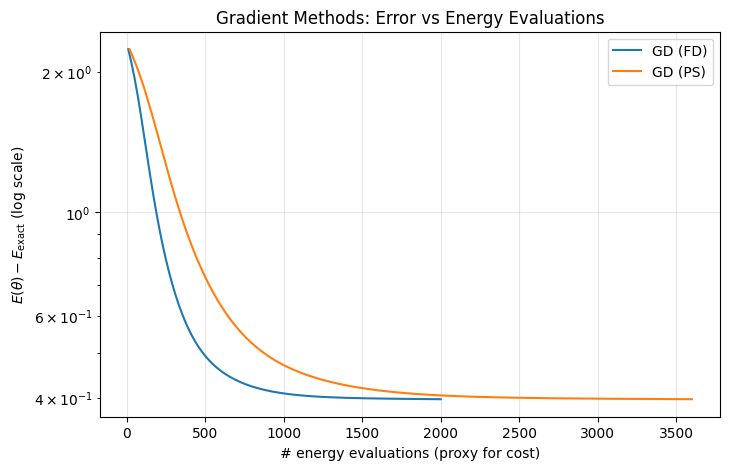

In [21]:
d = ansatz.num_parameters
plot_error_vs_evals(
    [gd_fd.history_energy, gd_ps.history_energy],
    ["GD", "GD"],
    ["FD", "PS"],
    E_exact, d,
    "Gradient Methods: Error vs Energy Evaluations"
)


/tmp/ipython-input-1596575982.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["GD", "Adam", "QNG"])


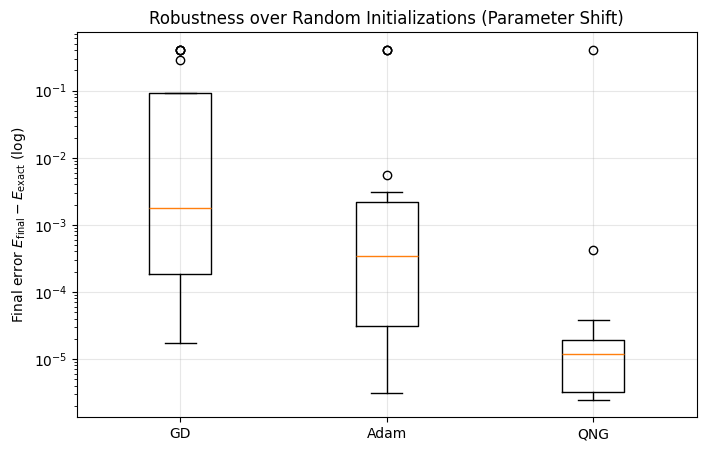

In [22]:
def run_many(optimizer_factory, grad_fn, n_trials=20, seed0=0):
    finals = []
    iters = []
    for s in range(seed0, seed0+n_trials):
        np.random.seed(s)
        theta0 = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
        opt = optimizer_factory()
        _, _ = opt.run(theta0, energy, grad_fn)
        finals.append(opt.history_energy[-1])
        iters.append(len(opt.history_energy))
    return np.array(finals), np.array(iters)

# Example: compare optimizers under parameter-shift
eta = ConstantStepSize(eta=0.05)

gd_factory   = lambda: GradientDescent(step_size=eta, max_iter=200)
adam_factory = lambda: Adam(lr=0.02, max_iter=200)
qng_factory  = lambda: QuantumNaturalGradient(step_size=eta, fim_fn=fim_fn, reg=1e-2, max_iter=200)

E_gd, it_gd     = run_many(gd_factory, grad_ps)
E_adam, it_adam = run_many(adam_factory, grad_ps)
E_qng, it_qng   = run_many(qng_factory, grad_ps)

plt.figure(figsize=(8,5))
data = [E_gd - E_exact, E_adam - E_exact, E_qng - E_exact]
plt.boxplot(data, labels=["GD", "Adam", "QNG"])
plt.yscale("log")
plt.ylabel(r"Final error $E_{\mathrm{final}} - E_{\mathrm{exact}}$ (log)")
plt.title("Robustness over Random Initializations (Parameter Shift)")
plt.grid(alpha=0.3)
plt.show()


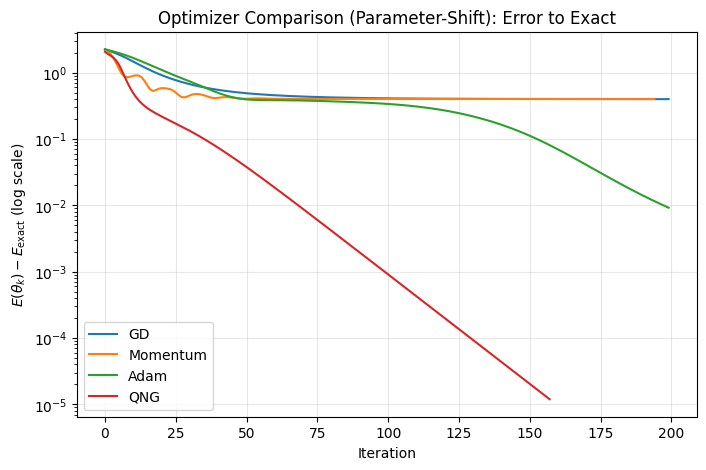

In [24]:
eta = ConstantStepSize(eta=0.05)

gd   = GradientDescent(step_size=eta, max_iter=200)
mom  = MomentumGD(step_size=eta, beta=0.9, max_iter=200)
adam = Adam(lr=0.02, max_iter=200)
qng  = QuantumNaturalGradient(step_size=eta, fim_fn=fim_fn, reg=1e-2, max_iter=200)

gd.run(theta0, energy, grad_ps)
mom.run(theta0, energy, grad_ps)
adam.run(theta0, energy, grad_ps)
qng.run(theta0, energy, grad_ps)

plot_error_curves(
    [gd.history_energy, mom.history_energy, adam.history_energy, qng.history_energy],
    ["GD", "Momentum", "Adam", "QNG"],
    E_exact,
    "Optimizer Comparison (Parameter-Shift): Error to Exact"
)


# Results and Plots

In [25]:
# Helper
# error-to-exact plotting (log scale): How far we are from the true ground-state energy?

def plot_error_curves(histories, labels, E_exact, title):
    plt.figure(figsize=(8,5))
    for hist, lab in zip(histories, labels):
        err = np.maximum(np.array(hist) - E_exact, 1e-16)
        plt.plot(err, label=lab)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel(r"$E(\theta_k) - E_{\mathrm{exact}}$")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


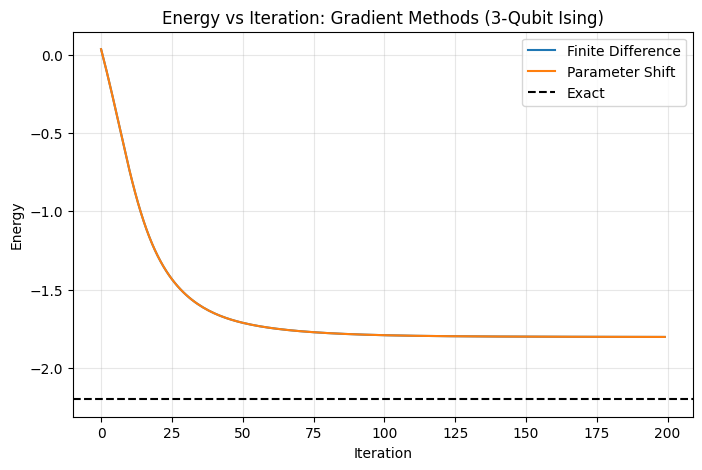

In [28]:
# PLOT 1: Gradient Method Comparison (FD vs PS)

eta = ConstantStepSize(eta=0.05)

gd_fd = GradientDescent(step_size=eta, max_iter=200)
gd_ps = GradientDescent(step_size=eta, max_iter=200)

gd_fd.run(theta0, energy, grad_fd)
gd_ps.run(theta0, energy, grad_ps)

plt.figure(figsize=(8,5))
plt.plot(gd_fd.history_energy, label="Finite Difference")
plt.plot(gd_ps.history_energy, label="Parameter Shift")
plt.axhline(E_exact, color="black", linestyle="--", label="Exact")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy vs Iteration: Gradient Methods (3-Qubit Ising)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



/tmp/ipython-input-3408093736.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([finals_gd - E_exact, finals_adam - E_exact], labels=["GD", "Adam"])


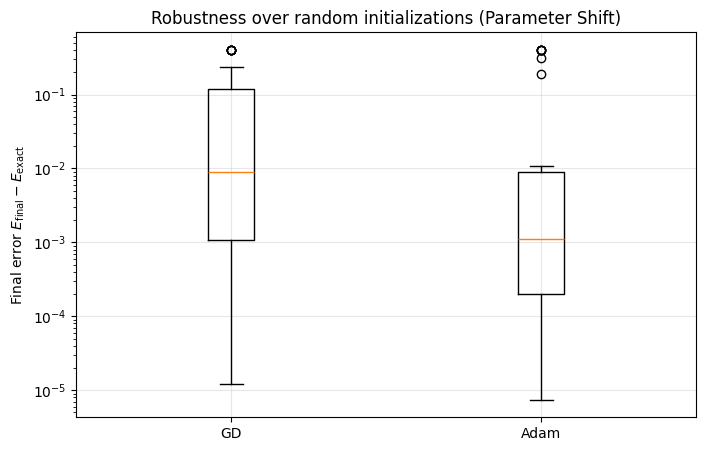

GD success rate: 0.23333333333333334
Adam success rate: 0.5


In [32]:
def run_trials(optimizer_factory, grad_fn, n_trials=30, seed0=0):
    finals = []
    for s in range(seed0, seed0+n_trials):
        np.random.seed(s)
        theta0 = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
        opt = optimizer_factory()
        opt.run(theta0, energy, grad_fn)
        finals.append(opt.history_energy[-1])
    return np.array(finals)

eta = ConstantStepSize(eta=0.05)
gd_factory = lambda: GradientDescent(step_size=eta, max_iter=200)
adam_factory = lambda: Adam(lr=0.02, max_iter=200)

finals_gd = run_trials(gd_factory, grad_ps, n_trials=30)
finals_adam = run_trials(adam_factory, grad_ps, n_trials=30)

plt.figure(figsize=(8,5))
plt.boxplot([finals_gd - E_exact, finals_adam - E_exact], labels=["GD", "Adam"])
plt.yscale("log")
plt.ylabel(r"Final error $E_{\mathrm{final}}-E_{\mathrm{exact}}$")
plt.title("Robustness over random initializations (Parameter Shift)")
plt.grid(alpha=0.3)
plt.show()

print("GD success rate:", np.mean(finals_gd < E_exact + 1e-3))
print("Adam success rate:", np.mean(finals_adam < E_exact + 1e-3))


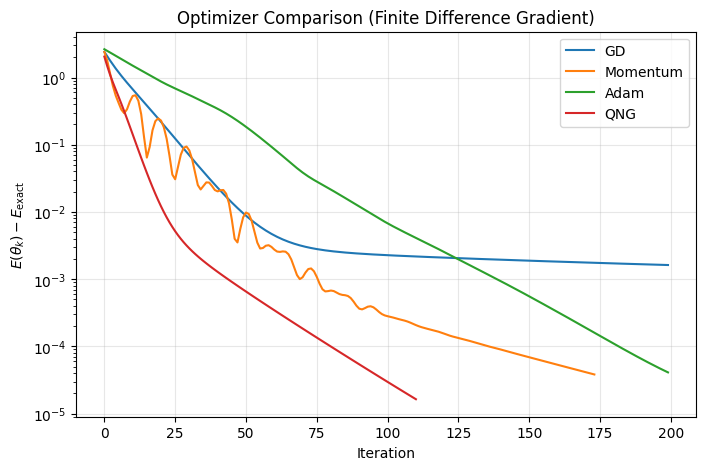

In [34]:
#PLOT 2 — Optimizer comparison (Finite-Difference gradient)
eta = ConstantStepSize(eta=0.05)

gd   = GradientDescent(step_size=eta, max_iter=200)
mom  = MomentumGD(step_size=eta, beta=0.9, max_iter=200)
adam = Adam(lr=0.02, max_iter=200)
qng  = QuantumNaturalGradient(step_size=eta, fim_fn=fim_fn, reg=1e-2, max_iter=200)

gd.run(theta0, energy, grad_fd)
mom.run(theta0, energy, grad_fd)
adam.run(theta0, energy, grad_fd)
qng.run(theta0, energy, grad_fd)

plot_error_curves(
    [gd.history_energy, mom.history_energy, adam.history_energy, qng.history_energy],
    ["GD", "Momentum", "Adam", "QNG"],
    E_exact,
    "Optimizer Comparison (Finite Difference Gradient)"
)


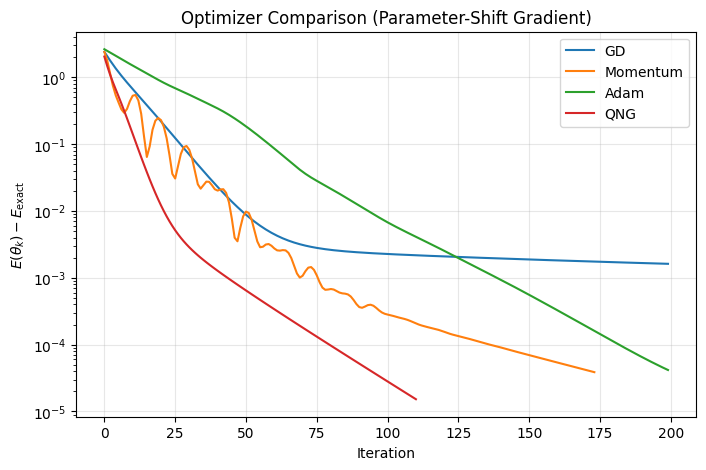

In [35]:
# PLOT 3 — Optimizer comparison (Parameter-Shift gradient)

gd   = GradientDescent(step_size=eta, max_iter=200)
mom  = MomentumGD(step_size=eta, beta=0.9, max_iter=200)
adam = Adam(lr=0.02, max_iter=200)
qng  = QuantumNaturalGradient(step_size=eta, fim_fn=fim_fn, reg=1e-2, max_iter=200)

gd.run(theta0, energy, grad_ps)
mom.run(theta0, energy, grad_ps)
adam.run(theta0, energy, grad_ps)
qng.run(theta0, energy, grad_ps)

plot_error_curves(
    [gd.history_energy, mom.history_energy, adam.history_energy, qng.history_energy],
    ["GD", "Momentum", "Adam", "QNG"],
    E_exact,
    "Optimizer Comparison (Parameter-Shift Gradient)"
)


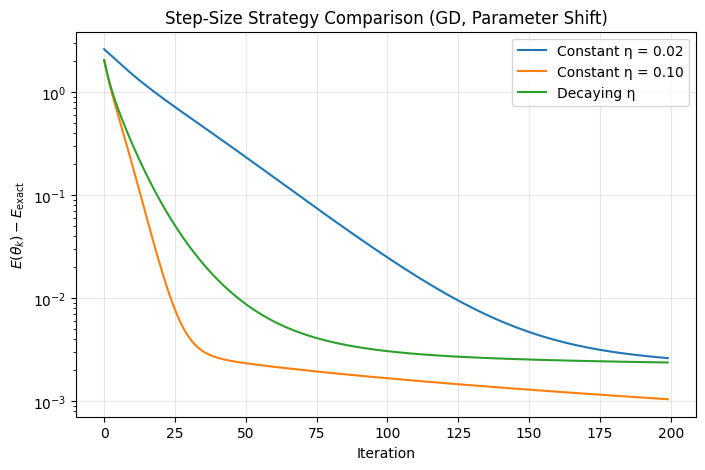

In [36]:
# PLOT 4 — Step-size strategy comparison (GD + PS gradient)
eta_small = ConstantStepSize(eta=0.02)
eta_large = ConstantStepSize(eta=0.10)
eta_decay = DecayingStepSize(eta0=0.10, decay=0.05)

gd_small = GradientDescent(step_size=eta_small, max_iter=200)
gd_large = GradientDescent(step_size=eta_large, max_iter=200)
gd_decay = GradientDescent(step_size=eta_decay, max_iter=200)

gd_small.run(theta0, energy, grad_ps)
gd_large.run(theta0, energy, grad_ps)
gd_decay.run(theta0, energy, grad_ps)

plot_error_curves(
    [gd_small.history_energy, gd_large.history_energy, gd_decay.history_energy],
    ["Constant η = 0.02", "Constant η = 0.10", "Decaying η"],
    E_exact,
    "Step-Size Strategy Comparison (GD, Parameter Shift)"
)


In [37]:
# Error vs energy evaluations (cost-aware)
def plot_error_vs_evals(histories, labels, methods, E_exact, d, title):
    plt.figure(figsize=(8,5))
    for hist, lab, m in zip(histories, labels, methods):
        if m == "FD":
            evals = (d + 1) * np.arange(1, len(hist)+1)
        elif m == "PS":
            evals = (2 * d) * np.arange(1, len(hist)+1)
        err = np.maximum(np.array(hist) - E_exact, 1e-16)
        plt.plot(evals, err, label=lab)
    plt.yscale("log")
    plt.xlabel("# Energy Evaluations")
    plt.ylabel(r"$E - E_{\mathrm{exact}}$")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


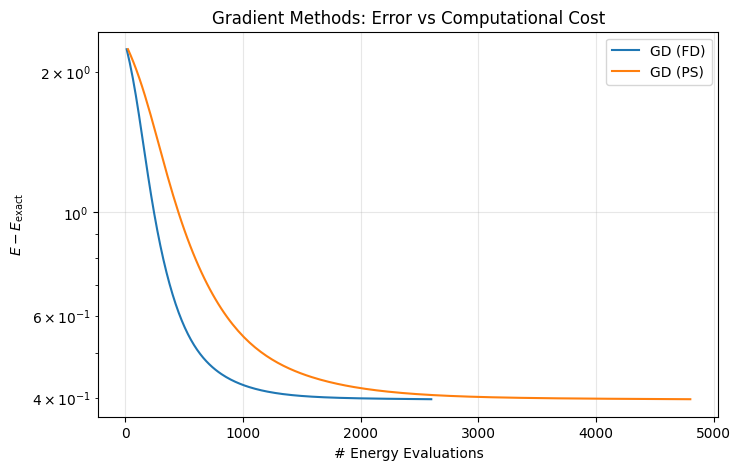

In [38]:
d = ansatz.num_parameters
plot_error_vs_evals(
    [gd_fd.history_energy, gd_ps.history_energy],
    ["GD (FD)", "GD (PS)"],
    ["FD", "PS"],
    E_exact, d,
    "Gradient Methods: Error vs Computational Cost"
)


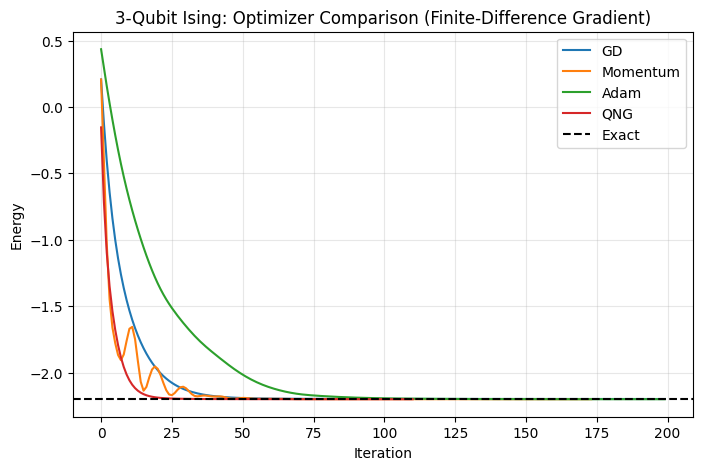

In [40]:
eta = ConstantStepSize(eta=0.05)

gd   = GradientDescent(step_size=eta, max_iter=200)
mom  = MomentumGD(step_size=eta, beta=0.9, max_iter=200)
adam = Adam(lr=0.02, max_iter=200)
qng  = QuantumNaturalGradient(step_size=eta, fim_fn=fim_fn, reg=1e-2, max_iter=200)

gd.run(theta0, energy, grad_fd)
mom.run(theta0, energy, grad_fd)
adam.run(theta0, energy, grad_fd)
qng.run(theta0, energy, grad_fd)

plt.figure(figsize=(8,5))
plt.plot(gd.history_energy, label="GD")
plt.plot(mom.history_energy, label="Momentum")
plt.plot(adam.history_energy, label="Adam")
plt.plot(qng.history_energy, label="QNG")
plt.axhline(E_exact, color="black", linestyle="--", label="Exact")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("3-Qubit Ising: Optimizer Comparison (Finite-Difference Gradient)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


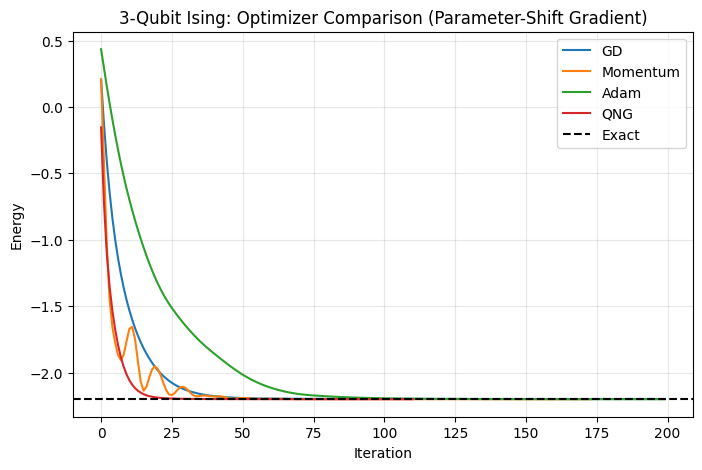

In [41]:
gd   = GradientDescent(step_size=eta, max_iter=200)
mom  = MomentumGD(step_size=eta, beta=0.9, max_iter=200)
adam = Adam(lr=0.02, max_iter=200)
qng  = QuantumNaturalGradient(step_size=eta, fim_fn=fim_fn, reg=1e-2, max_iter=200)

gd.run(theta0, energy, grad_ps)
mom.run(theta0, energy, grad_ps)
adam.run(theta0, energy, grad_ps)
qng.run(theta0, energy, grad_ps)

plt.figure(figsize=(8,5))
plt.plot(gd.history_energy, label="GD")
plt.plot(mom.history_energy, label="Momentum")
plt.plot(adam.history_energy, label="Adam")
plt.plot(qng.history_energy, label="QNG")
plt.axhline(E_exact, color="black", linestyle="--", label="Exact")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("3-Qubit Ising: Optimizer Comparison (Parameter-Shift Gradient)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


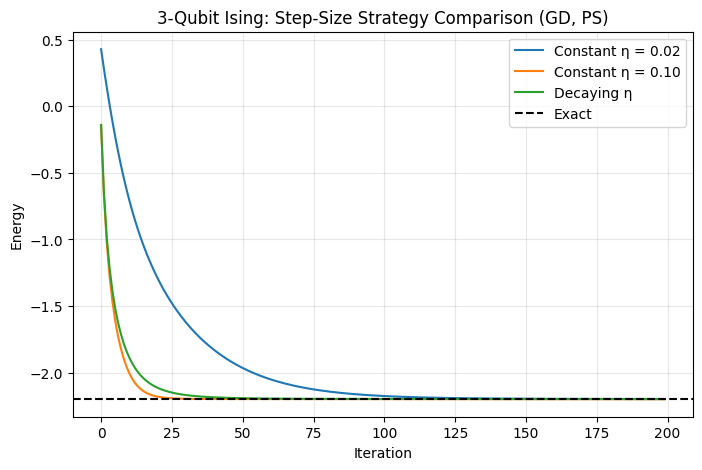

In [44]:
eta_small = ConstantStepSize(eta=0.02)
eta_large = ConstantStepSize(eta=0.10)
eta_decay = DecayingStepSize(eta0=0.10, decay=0.05)

gd_small = GradientDescent(step_size=eta_small, max_iter=200)
gd_large = GradientDescent(step_size=eta_large, max_iter=200)
gd_decay = GradientDescent(step_size=eta_decay, max_iter=200)

gd_small.run(theta0, energy, grad_ps)
gd_large.run(theta0, energy, grad_ps)
gd_decay.run(theta0, energy, grad_ps)

plt.figure(figsize=(8,5))
plt.plot(gd_small.history_energy, label="Constant η = 0.02")
plt.plot(gd_large.history_energy, label="Constant η = 0.10")
plt.plot(gd_decay.history_energy, label="Decaying η")
plt.axhline(E_exact, color="black", linestyle="--", label="Exact")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("3-Qubit Ising: Step-Size Strategy Comparison (GD, PS)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


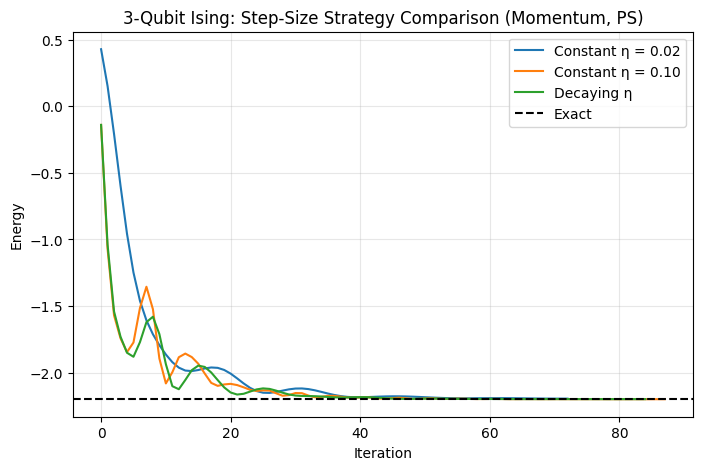

In [45]:

# Step-size Strategy Comparison (Momentum Optimizer)


eta_small = ConstantStepSize(eta=0.02)
eta_large = ConstantStepSize(eta=0.10)
eta_decay = DecayingStepSize(eta0=0.10, decay=0.05)

mom_small = MomentumGD(step_size=eta_small, beta=0.9, max_iter=200)
mom_large = MomentumGD(step_size=eta_large, beta=0.9, max_iter=200)
mom_decay = MomentumGD(step_size=eta_decay, beta=0.9, max_iter=200)

mom_small.run(theta0, energy, grad_ps)
mom_large.run(theta0, energy, grad_ps)
mom_decay.run(theta0, energy, grad_ps)

plt.figure(figsize=(8,5))
plt.plot(mom_small.history_energy, label="Constant η = 0.02")
plt.plot(mom_large.history_energy, label="Constant η = 0.10")
plt.plot(mom_decay.history_energy, label="Decaying η")
plt.axhline(E_exact, color="black", linestyle="--", label="Exact")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("3-Qubit Ising: Step-Size Strategy Comparison (Momentum, PS)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


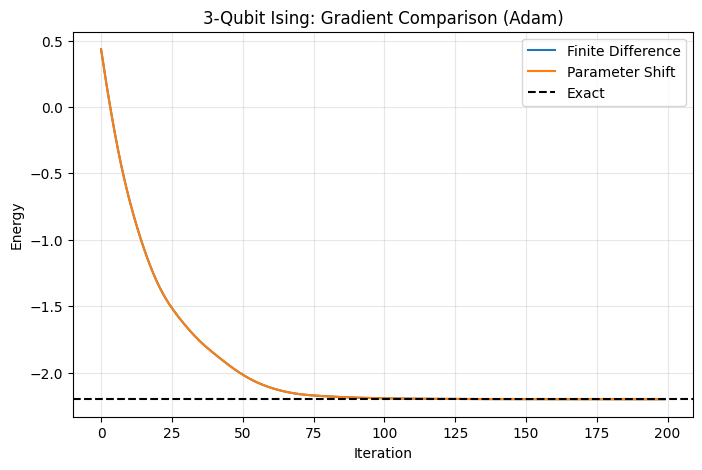

In [46]:
adam_fd = Adam(lr=0.02, max_iter=200)
adam_ps = Adam(lr=0.02, max_iter=200)

adam_fd.run(theta0, energy, grad_fd)
adam_ps.run(theta0, energy, grad_ps)

plt.figure(figsize=(8,5))
plt.plot(adam_fd.history_energy, label="Finite Difference")
plt.plot(adam_ps.history_energy, label="Parameter Shift")
plt.axhline(E_exact, color="black", linestyle="--", label="Exact")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("3-Qubit Ising: Gradient Comparison (Adam)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


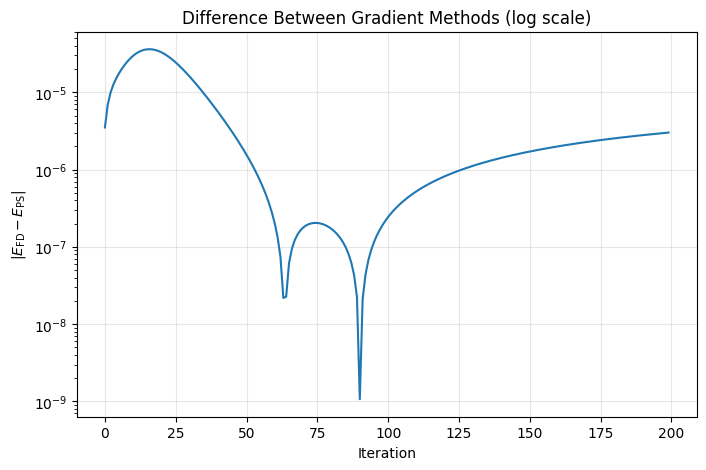

In [47]:

# Gradient Difference Plot (log scale)


eta = ConstantStepSize(eta=0.05)

gd_fd = GradientDescent(step_size=eta, max_iter=200)
gd_ps = GradientDescent(step_size=eta, max_iter=200)

gd_fd.run(theta0, energy, grad_fd)
gd_ps.run(theta0, energy, grad_ps)

# Compute absolute difference between energies
diff = np.abs(
    np.array(gd_fd.history_energy) -
    np.array(gd_ps.history_energy)
)

plt.figure(figsize=(8,5))
plt.plot(diff)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel(r"$|E_{\mathrm{FD}} - E_{\mathrm{PS}}|$")
plt.title("Difference Between Gradient Methods (log scale)")
plt.grid(alpha=0.3)
plt.show()
